<a href="https://colab.research.google.com/github/vincentjordan27/Named-Entity-Recognition-BILSTM-CRF/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import sys
import csv
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader



In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchtext==0.6.0
!pip install pytorch-crf

import time
import gensim
import torch
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from torchcrf import CRF
from collections import Counter
from spacy.lang.id import Indonesian

In [27]:
class Corpus(object):

  def __init__(self, input_folder, min_word_freq, batch_size):
    self.word_field = Field(lower=True)
    self.tag_field = Field(unk_token=None)
    self.train_dataset, self.val_dataset, self.test_dataset = SequenceTaggingDataset.splits(
        path=input_folder,
        train="train.tsv",
        validation="val.tsv",
        test="test.tsv",
        fields=(("word", self.word_field), ("tag", self.tag_field))
    )
    self.word_field.build_vocab(self.train_dataset.word, min_freq=min_word_freq)
    self.tag_field.build_vocab(self.train_dataset.tag)

    self.train_iter, self.val_iter, self.test_iter = BucketIterator.splits(
        datasets=(self.train_dataset, self.val_dataset, self.test_dataset),
        batch_size=batch_size
    )
    self.word_pad_idx = self.word_field.vocab.stoi[self.word_field.pad_token]
    self.tag_pad_idx = self.tag_field.vocab.stoi[self.tag_field.pad_token]
    

In [28]:
corpus = Corpus(
    input_folder="/content/drive/My Drive/Colab Notebooks/",
    min_word_freq=1, 
    batch_size=64,
)
print(f"Train set: {len(corpus.train_dataset)} kata")
print(f"Val set: {len(corpus.val_dataset)} kata")
print(f"Test set: {len(corpus.test_dataset)} kata")

Train set: 3535 kata
Val set: 470 kata
Test set: 468 kata


In [29]:
class BiLSTM(nn.Module):

  def __init__(self, 
               input_dim, 
               embedding_dim, 
               hidden_dim, 
               output_dim, 
               lstm_layers,
               emb_dropout, 
               lstm_dropout, 
               fc_dropout, 
               word_pad_idx,
               tag_pad_idx):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.embedding = nn.Embedding(
        num_embeddings=input_dim, 
        embedding_dim=embedding_dim, 
        padding_idx=word_pad_idx
    )
    self.emb_dropout = nn.Dropout(emb_dropout)
    self.lstm = nn.LSTM(
        input_size=embedding_dim,
        hidden_size=hidden_dim,
        num_layers=lstm_layers,
        bidirectional=True,
        dropout=lstm_dropout if lstm_layers > 1 else 0
    )
    self.fc_dropout = nn.Dropout(fc_dropout)
    self.fc = nn.Linear(hidden_dim * 2, output_dim)  

    #CRF
    self.tag_pad_idx = tag_pad_idx
    self.crf = CRF(num_tags=output_dim)

  def forward(self, sentence):
    embedding_out = self.emb_dropout(self.embedding(sentence))
    lstm_out, _ = self.lstm(embedding_out)
    ner_out = self.fc(self.fc_dropout(lstm_out))
    return ner_out

  def init_weights(self):
    for name, param in self.named_parameters():
      nn.init.normal_(param.data, mean=0, std=0.1)

  def init_embeddings(self, word_pad_idx):
    self.embedding.weight.data[word_pad_idx] = torch.zeros(self.embedding_dim)

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

  
  #crf output
  def init_crf_transitions(self, tag_names, imp_value=-100):
        num_tags = len(tag_names)
        for i in range(num_tags):
            tag_name = tag_names[i]
            # I and L and <pad> impossible as a start
            if tag_name[0] in ("I", "L") or tag_name == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
            # B and I impossible as an end
            if tag_name[0] in ("B", "I"):
                torch.nn.init.constant_(self.crf.end_transitions[i], imp_value)
        # init impossible transitions between positions
        tag_is = {}
        for tag_position in ("B", "I", "O", "U", "L"):
            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        tag_is["P"] = [i for i, tag in enumerate(tag_names) if tag == "tag"]
        impossible_transitions_position = {
            "B": "BOUP",
            "I": "BOUP",
            "O": "IL",
            "U": "IL",
            "L": "IL"
        }
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
        # init impossible B and I transitions to different entity types
        impossible_transitions_tags = {
            "B": "IL",
            "I": "IL"
        }
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )
    ### END MODIFIED SECTION: CRF OUTPUT ###

In [30]:
bilstm = BiLSTM(
    input_dim=len(corpus.word_field.vocab),
    embedding_dim=10,
    hidden_dim=8,
    output_dim=len(corpus.tag_field.vocab),
    lstm_layers=1,
    emb_dropout=0.5,
    lstm_dropout=0.1,
    fc_dropout=0.25,
    word_pad_idx=corpus.word_pad_idx, 
    tag_pad_idx=corpus.tag_pad_idx
)
bilstm.init_weights()
bilstm.init_embeddings(word_pad_idx=corpus.word_pad_idx)
bilstm.init_crf_transitions(
    tag_names=corpus.tag_field.vocab.itos
)

print(f"The model has {bilstm.count_parameters():,} trainable parameters.")
print(bilstm)
print(len(corpus.word_field.vocab))

The model has 106,152 trainable parameters.
BiLSTM(
  (embedding): Embedding(10397, 10, padding_idx=1)
  (emb_dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(10, 8, bidirectional=True)
  (fc_dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=16, out_features=22, bias=True)
  (crf): CRF(num_tags=22)
)
10397


In [31]:
def print_crf_transitions(c, m):
    tags = c.tag_field.vocab.itos
    max_len_tag = max([len(tag) for tag in tags])
    print("Start and end tag transitions:")
    print(f"{'TAG'.ljust(max_len_tag)}\tSTART\tEND")
    for tag, start_prob, end_prob in zip(tags, m.crf.start_transitions.tolist(), m.crf.end_transitions.tolist()):
        print(f"{tag.ljust(max_len_tag)}\t{round(start_prob, 2)}\t{round(end_prob, 2)}")
    print()
    print("Between tags transitions:")
    persons_i = [i for i, tag in enumerate(c.tag_field.vocab.itos) if "PERSON" in tag or "TIME" in tag or tag == "O"]
    max_len_tag = max([len(tag) for tag in c.tag_field.vocab.itos if "PERSON" in tag or "TIME" in tag])
    transitions = m.crf.transitions
    to_tags = "TO".rjust(max_len_tag) + "\t" + "\t".join([tag.ljust(max_len_tag) for tag in tags if "PERSON" in tag or "TIME" in tag or tag == "O"])
    print(to_tags)
    print("FROM")
    for from_tag_i, from_tag_probs in enumerate(transitions[persons_i]):
        to_tag_str = f"{tags[persons_i[from_tag_i]].ljust(max_len_tag)}"
        for to_tag_prob in from_tag_probs[persons_i]:
            to_tag_str += f"\t{str(round(to_tag_prob.item(), 2)).ljust(max_len_tag)}"
        print(to_tag_str)

print_crf_transitions(corpus, bilstm)

Start and end tag transitions:
TAG           	START	END
<pad>         	-100.0	0.02
O             	-0.05	-0.03
U-ORGANIZATION	0.2	-0.07
U-PERSON      	-0.2	0.11
U-LOCATION    	-0.02	0.02
B-PERSON      	-0.25	-100.0
L-PERSON      	-100.0	-0.07
B-ORGANIZATION	0.04	-100.0
L-ORGANIZATION	-100.0	0.03
I-ORGANIZATION	-100.0	-100.0
B-LOCATION    	0.1	-100.0
L-LOCATION    	-100.0	0.14
I-TIME        	-100.0	-100.0
B-QUANTITY    	-0.06	-100.0
L-QUANTITY    	-100.0	0.06
I-PERSON      	-100.0	-100.0
I-QUANTITY    	-100.0	-100.0
I-LOCATION    	-100.0	-100.0
B-TIME        	-0.03	-100.0
L-TIME        	-100.0	0.01
U-TIME        	0.04	0.09
U-QUANTITY    	-0.02	-0.05

Between tags transitions:
      TO	O       	U-PERSON	B-PERSON	L-PERSON	I-TIME  	I-PERSON	B-TIME  	L-TIME  	U-TIME  
FROM
O       	0.03    	0.04    	0.05    	-100.0  	-100.0  	-100.0  	0.09    	-100.0  	-0.05   
U-PERSON	-0.12   	0.2     	0.19    	-100.0  	-100.0  	-100.0  	0.04    	-100.0  	-0.2    
B-PERSON	-100.0  	-100.0  	-100.0  	-0.09 

In [39]:
class NER(object):

  def __init__(self, model, data, optimizer_cls, loss_fn_cls):
    self.model = model
    self.data = data
    self.optimizer = optimizer_cls(model.parameters())
    self.loss_fn = loss_fn_cls(ignore_index=self.data.tag_pad_idx)

  @staticmethod
  def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

  def accuracy(self, preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True) 
    non_pad_elements = (y != self.data.tag_pad_idx).nonzero() 
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])

  def epoch(self):
      epoch_loss = 0
      epoch_acc = 0
      self.model.train()
      for batch in self.data.train_iter:
        text = batch.word
        true_tags = batch.tag
        self.optimizer.zero_grad()
        pred_tags = self.model(text)
        pred_tags = pred_tags.view(-1, pred_tags.shape[-1])
        true_tags = true_tags.view(-1)
        batch_loss = self.loss_fn(pred_tags, true_tags)
        batch_acc = self.accuracy(pred_tags, true_tags)
        print
        batch_loss.backward()
        self.optimizer.step()
        epoch_loss += batch_loss.item()
        epoch_acc += batch_acc.item()
      return epoch_loss / len(self.data.train_iter), epoch_acc / len(self.data.train_iter)

  def evaluate(self, iterator):
      epoch_loss = 0
      epoch_acc = 0
      self.model.eval()
      with torch.no_grad():

          for batch in iterator:
              text = batch.word
              true_tags = batch.tag
              pred_tags = self.model(text)
              pred_tags = pred_tags.view(-1, pred_tags.shape[-1])
              true_tags = true_tags.view(-1)
              batch_loss = self.loss_fn(pred_tags, true_tags)
              batch_acc = self.accuracy(pred_tags, true_tags)
              epoch_loss += batch_loss.item()
              epoch_acc += batch_acc.item()
      return epoch_loss / len(iterator), epoch_acc / len(iterator)

  ### BEGIN MODIFIED SECTION: EXPERIMENT ###
  def train(self, n_epochs):
        history = {
            "num_params": self.model.count_parameters(),
            "train_loss": [],
            "train_f1": [],
            "val_loss": [],
            "val_f1": [],
        }
        elapsed_train_time = 0
        for epoch in range(n_epochs):
            start_time = time.time()
            train_loss, train_f1 = self.epoch()
            end_time = time.time()
            elapsed_train_time += end_time - start_time
            history["train_loss"].append(train_loss)
            history["train_f1"].append(train_f1)
            val_loss, val_f1 = self.evaluate(self.data.val_iter)
            history["val_loss"].append(val_loss)
            history["val_f1"].append(val_f1)
        test_loss, test_f1 = self.evaluate(self.data.test_iter)
        history["test_loss"] = test_loss
        history["test_f1"] = test_f1
        history["elapsed_train_time"] = elapsed_train_time
        return history
    ### END MODIFIED SECTION ###

  def trainer(self, n_epochs):
      for epoch in range(n_epochs):
          start_time = time.time()
          train_loss, train_acc = self.epoch()
          end_time = time.time()
          epoch_mins, epoch_secs = NER.epoch_time(start_time, end_time)
          print(f"Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
          print(f"\tTrn Loss: {train_loss:.3f} | Trn Acc: {train_acc * 100:.2f}%")
          val_loss, val_acc = self.evaluate(self.data.val_iter)
          print(f"\tVal Loss: {val_loss:.3f} | Val Acc: {val_acc * 100:.2f}%")
      test_loss, test_acc = self.evaluate(self.data.test_iter)
      print(f"Test Loss: {test_loss:.3f} |  Test Acc: {test_acc * 100:.2f}%")
  
  

In [40]:
num_epochs = 10
histories = {}
for model_name in configs:
    print(f"Start Training: {model_name}")
    ner = NER(
      model=bilstm,
      data=corpus,
      optimizer_cls=Adam,
      loss_fn_cls=nn.CrossEntropyLoss
    )
    histories[model_name] = ner.trainer(num_epochs)
    print(f"Done Training: {model_name}")
    print()

Start Training: bilstm
Epoch: 01 | Epoch Time: 0m 1s
	Trn Loss: 0.712 | Trn Acc: 83.03%
	Val Loss: 0.608 | Val Acc: 85.67%
Epoch: 02 | Epoch Time: 0m 1s
	Trn Loss: 0.675 | Trn Acc: 83.13%
	Val Loss: 0.594 | Val Acc: 85.68%
Epoch: 03 | Epoch Time: 0m 1s
	Trn Loss: 0.649 | Trn Acc: 83.22%
	Val Loss: 0.585 | Val Acc: 85.48%
Epoch: 04 | Epoch Time: 0m 1s
	Trn Loss: 0.636 | Trn Acc: 83.17%
	Val Loss: 0.578 | Val Acc: 85.10%
Epoch: 05 | Epoch Time: 0m 1s
	Trn Loss: 0.619 | Trn Acc: 83.20%
	Val Loss: 0.572 | Val Acc: 84.88%
Epoch: 06 | Epoch Time: 0m 1s
	Trn Loss: 0.604 | Trn Acc: 83.29%
	Val Loss: 0.566 | Val Acc: 84.82%
Epoch: 07 | Epoch Time: 0m 1s
	Trn Loss: 0.592 | Trn Acc: 83.49%
	Val Loss: 0.559 | Val Acc: 84.91%
Epoch: 08 | Epoch Time: 0m 1s
	Trn Loss: 0.574 | Trn Acc: 83.93%
	Val Loss: 0.553 | Val Acc: 85.22%
Epoch: 09 | Epoch Time: 0m 1s
	Trn Loss: 0.563 | Trn Acc: 84.22%
	Val Loss: 0.547 | Val Acc: 85.40%
Epoch: 10 | Epoch Time: 0m 1s
	Trn Loss: 0.556 | Trn Acc: 84.49%
	Val Loss: 0

In [47]:
# configurations building block

base = {
    "input_dim": len(corpus.word_field.vocab),
    "output_dim":len(corpus.tag_field.vocab),
    "word_pad_idx": corpus.word_pad_idx,
    "tag_pad_idx": corpus.tag_pad_idx
}
configs = {
    "bilstm-crf": base
}

In [44]:
histori = {}
histori[model_name] = ner.train(num_epochs)
max_len_model_name = max([len(m) for m in histori])
print(f"{'MODEL NAME'.ljust(max_len_model_name)}\t{'NUM PARAMS'.ljust(10)}\tTRAINING TIME")
for model_name, history in histori.items():
  print(f"{model_name.ljust(max_len_model_name)}\t{history['num_params']:,}\t{int(history['elapsed_train_time']//60)}m {int(history['elapsed_train_time'] % 60)}s")

MODEL NAME	NUM PARAMS	TRAINING TIME
bilstm	106,152	0m 16s


In [36]:
import matplotlib.pyplot as plt

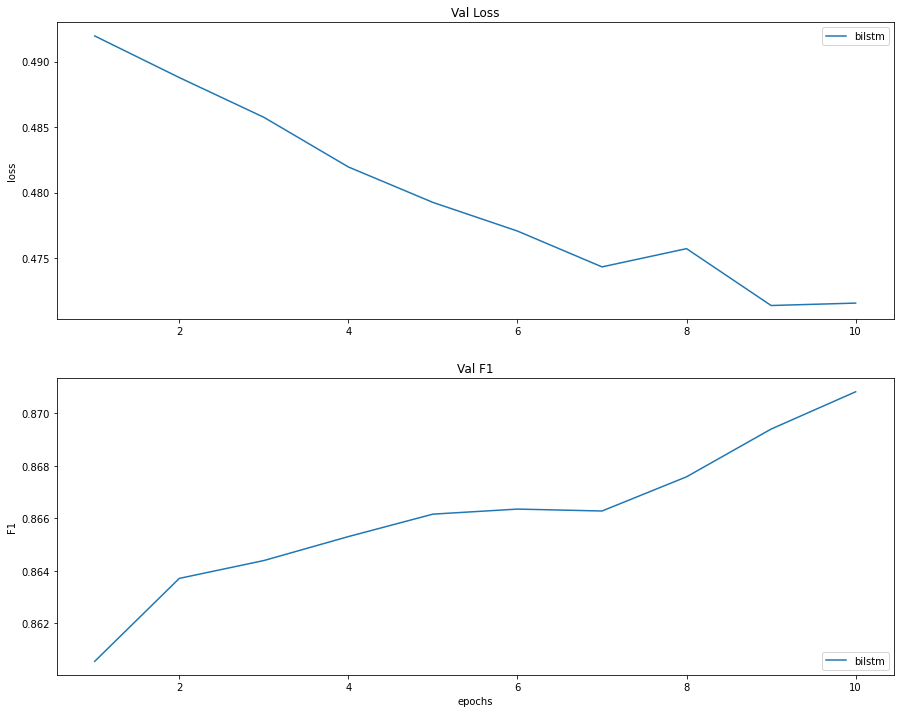

In [50]:
epochs = [i+1 for i in range(10)]

val_loss = histori["bilstm"]["val_loss"]

fig, axs = plt.subplots(2, 1, figsize=(15, 12))
for model_name in histori:
    axs[0].plot(epochs, histori[model_name]["val_loss"], label=model_name)
    axs[1].plot(epochs, histori[model_name]["val_f1"], label=model_name)
_ = axs[0].set_title("Val Loss")
_ = axs[1].set_title("Val F1")
_ = axs[1].set_xlabel("epochs")
_ = axs[0].set_ylabel("loss")
_ = axs[1].set_ylabel("F1")
_ = axs[0].legend(loc="upper right")
_ = axs[1].legend(loc="lower right")

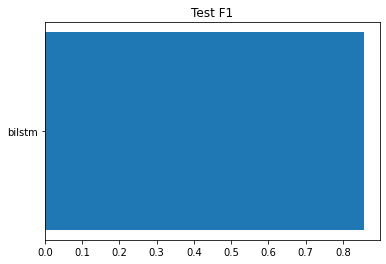

In [52]:
model_test_f1 = [(m, histori[m]["test_f1"]) for m in histori]
model_test_f1_sorted = sorted(model_test_f1, key=lambda m: m[1])
model_names = [m[0] for m in model_test_f1_sorted]
y_pos = list(range(len(model_names)))
f1_scores = [m[1] for m in model_test_f1_sorted]
fig, ax = plt.subplots()
_ = ax.barh(y_pos, f1_scores, align='center')
_ = ax.set_yticks(y_pos)
_ = ax.set_yticklabels(model_names)
_ = ax.set_title("Test F1")